<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture05/notebooks/CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN en CIFAR-10

En este cuaderno, debes poner en práctica lo que has aprendido y crear tu propio clasificador convolucional para el conjunto de datos CIFAR-10.

Las imágenes en CIFAR-10 son imágenes RGB (3 canales) con tamaño 32x32 (es decir, tienen un tamaño de 3x32x32). Hay 10 clases diferentes. A continuación, se muestran algunos ejemplos.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(),
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1].
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

100%|██████████| 170498071/170498071 [00:12<00:00, 13314717.87it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Mostrar imágenes de ejemplo

Ejecuta varias veces para ver diferentes ejemplos.


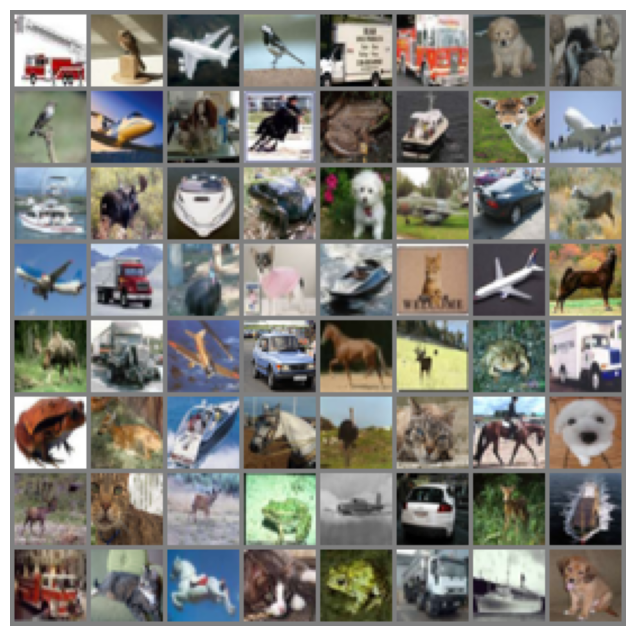

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define una red neuronal convolucional

**Tarea 1:** Define una red neuronal convolucional.  
Puedes utilizar el código de cuadernos anteriores.  
Te sugerimos que comiences con una red pequeña y te asegures de que todo esté funcionando correctamente.  
Una vez que puedas entrenar con éxito, vuelve y mejora la arquitectura.

In [ ]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""

    first = True

    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!

    def forward(self, x):
        # Your code here!
        return x


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

## Define una función de pérdida y un optimizador

**Tarea 2:** Define la función de pérdida y el optimizador.  
Es posible que necesites experimentar un poco con la tasa de aprendizaje.

In [ ]:
loss_fn = None  # Your code here!
optimizer = None  # Your code here!


## Entrena la red

**Tarea 3:** Completa el bucle de entrenamiento a continuación.  
Comienza utilizando un número pequeño de épocas (por ejemplo, 2).  
Incluso con un número bajo de épocas deberías poder ver resultados que son mejores que el azar.  
Cuando todo esté funcionando, aumenta el número de épocas para descubrir qué tan buena es realmente tu red.


In [ ]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

In [ ]:
batch_size = 64
num_epochs = 2
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):

    train_accuracies_batches = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))

            train_accuracies_batches = []

            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()

            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

## Prueba la red

Ahora mostramos un lote de imágenes de prueba y generamos una tabla a continuación con la clase verdadera y la clase predicha para cada una de estas imágenes.


In [ ]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


Ahora evaluamos la red como se hizo anteriormente, pero en todo el conjunto de prueba.

In [ ]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)

    model.train()


Aquí informamos la **precisión promedio en la prueba** (número de predicciones correctas dividido por el tamaño del conjunto de prueba).


In [ ]:
print(f"Test accuracy: {test_accuracy:.3f}")

Aquí examinamos un poco más a fondo el rendimiento del clasificador utilizando la **matriz de confusión**. La entrada en la fila i y columna j indica el número de muestras con etiqueta verdadera siendo la clase i y etiqueta predicha siendo la clase j.

Normalizamos las filas: dado un conjunto de ejemplos de una clase específica (fila), podemos observar cómo son clasificados por nuestro modelo. Idealmente, nos gustaría que las entradas en las diagonales fueran 1, y todo lo demás 0. Esto significaría que todos los ejemplos de esa clase están clasificados correctamente.

Las clases que son más difíciles de clasificar para nuestro modelo tienen números más bajos en la diagonal. Luego podemos ver exactamente *cómo* se clasifican incorrectamente observando el resto de la fila.



In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Aquí nos enfocamos en la diagonal y representamos los números en un gráfico de barras. Esto nos da una imagen más clara de la precisión del modelo para diferentes clases.


In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Tarea 4:**
1. Vuelve atrás y mejora el rendimiento de la red. Usando suficientes capas convolucionales con suficientes canales (y entrenando durante el tiempo suficiente), deberías poder alcanzar fácilmente una precisión de prueba superior al 60%. ¡Pero ve hasta dónde puedes llegar! ¿Puedes alcanzar el 70%?

2. Describe brevemente lo que hiciste y cualquier experimento que realizaste, así como los resultados que obtuviste.
¿Hubo algo que te sorprendiera durante el ejercicio?
¿Cuáles fueron los cambios que parecieron mejorar el rendimiento más?

3. Escribe las lecciones o conocimientos clave que obtuviste durante este ejercicio.

**Respuesta:**


# Entrenamiento en GPU

**Tarea Opcional:**
Si tienes una GPU, te sugerimos que intentes entrenar tu modelo en la GPU. Para ello, necesitas mover el modelo a la GPU después de definirlo, lo que recorrerá recursivamente todos los módulos y convertirá sus parámetros y buffers a tensores CUDA. También necesitas transferir tanto las entradas como los objetivos a la GPU en cada paso de entrenamiento, antes de realizar la pasada hacia adelante.

El código para esto ya está en su lugar: nota las declaraciones `.to(device)`. Lo único que queda por hacer es cambiar la definición de `device` de `'cpu'` a `'cuda'`.

Si no tienes una GPU, puedes hacerlo en [Google Colab](https://research.google.com/colaboratory/).

Usa el código a continuación para verificar si hay alguna GPU disponible en tu configuración actual. Esto debería imprimir los modelos de todas las GPUs disponibles.



In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Es posible que no notes una aceleración significativa al usar una GPU. Esto probablemente se deba a que tu red es realmente pequeña. Intenta aumentar el ancho de tu red (número de canales en las capas convolucionales) y observa si notas alguna aceleración en la GPU en comparación con la CPU.


# Ejercicio del libro de Michael Nielsen

**Tarea 5:** Elige un ejercicio de tu preferencia del [libro de Michael Nielsen](http://neuralnetworksanddeeplearning.com/).

**Respuesta:**



